In [101]:
# run this once to download the model weights
! unzip "./model_weights.zip" -d "./"

  adding: model_weights.pth (172 bytes security) (deflated 7%)


In [1]:
# ! pip install tensorflow keras opencv-python Pillow

In [2]:
import os
import cv2
import numpy as np
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights, maskrcnn_resnet50_fpn
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
# import torchvision
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
# from sklearn.model_selection import train_test_split

C:\Users\rhasa\AppData\Local\Temp\ipykernel_34540\2153166883.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
annotations_df_original = pd.read_csv('./bttai-nybg-2024/annotations0.csv')

In [4]:
annotations_df_original["label_name"].value_counts()

label_name
measuring_object                     279
color_palate                         224
info_tag                             169
id_tag                               128
color_palate_and_measuring_object     98
miscellaneous                         50
Name: count, dtype: int64

In [5]:
# drop the rows with label_name = "info_tag"
annotations_df = annotations_df_original.drop(annotations_df_original[annotations_df_original["label_name"] == "miscellaneous"].index)

In [6]:
# annotations_df.drop(annotations_df[annotations_df["label_name"] == "info_tag"].index, inplace=True)

In [7]:
annotations_df["label_name"].value_counts()

label_name
measuring_object                     279
color_palate                         224
info_tag                             169
id_tag                               128
color_palate_and_measuring_object     98
Name: count, dtype: int64

In [8]:
len(list(annotations_df["image_name"].unique()))

396

In [9]:
dir1 = "./bttai-nybg-2024/BTTAIxNYBG-test/BTTAIxNYBG-test"
dir2 = "./bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train"
dir3 = "./bttai-nybg-2024/BTTAIxNYBG-validation/BTTAIxNYBG-validation"

In [10]:
image_filenames = annotations_df['image_name'].values

In [11]:
# Uncomment this if you are running it for the first time or you don't have the annotated images in the save_dir
save_dir = "./bttai-nybg-2024/annotated_images"
for image_filename in image_filenames:
    if os.path.exists(dir1 + "/" + image_filename):
        image_path = dir1 + "/" + image_filename
    elif os.path.exists(dir2 + "/" + image_filename):
        image_path = dir2 + "/" + image_filename
    elif os.path.exists(dir3 + "/" + image_filename):
        image_path = dir3 + "/" + image_filename
    else:
        print(f"Image not found: {image_filename}")
        break
    # save the image to the save_dir if it doesn't exist
    save_path = os.path.join(save_dir, image_filename)
    if not os.path.exists(save_path):
        img = cv2.imread(image_path)
        cv2.imwrite(save_path, img)
    else:
        print(f"Image already exists: {image_filename}")


Image already exists: 0000000000010109.jpg
Image already exists: 0000000000010109.jpg
Image already exists: 0000000410842681.jpg
Image already exists: 0000000410842681.jpg
Image already exists: 0000000410842681.jpg
Image already exists: 0000000a000d0001.jpg
Image already exists: 0000000a000d0001.jpg
Image already exists: 0000001818d060c1.jpg
Image already exists: 0000001818d060c1.jpg
Image already exists: 0000001818d060c1.jpg
Image already exists: 0000001818d060c1.jpg
Image already exists: 0000001818d060c1.jpg
Image already exists: 000000a270503034.jpg
Image already exists: 000000a270503034.jpg
Image already exists: 000000a270503034.jpg
Image already exists: 000000a270503034.jpg
Image already exists: 00000484a060a054.jpg
Image already exists: 00000484a060a054.jpg
Image already exists: 00000484a060a054.jpg
Image already exists: 00000484a060a054.jpg
Image already exists: 000006000818181d.jpg
Image already exists: 000006000818181d.jpg
Image already exists: 000006000818181d.jpg
Image alrea

In [12]:
def apply_gaussian_blur_and_edge_detection(image):
    # Convert PIL Image to numpy array
    image_np = np.array(image)
    
    #Modify the contrast and brightness of the image
    image_np = cv2.convertScaleAbs(image_np, alpha=1.1, beta=-100)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(image_np, (5,5), sigmaX=10)

    blurred_pil = Image.fromarray(blurred)

    # Convert to grayscale
    gray = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)

    gray_pil = Image.fromarray(gray)

    # Apply Canny edge detection
    edges = cv2.Canny(gray, threshold1=10, threshold2=95, L2gradient=True)

    kernel = np.ones((3, 3), np.uint8)
    closing = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    
    # Convert single channel image to 3 channels
    edges_3channel = np.stack((closing,)*3, axis=-1)

    # Dilate edges
    dilated_edges = cv2.dilate(edges_3channel, kernel=None, iterations=1)

    # Convert numpy array back to PIL Image
    edges_pil = Image.fromarray(dilated_edges)

    enhanced_image = cv2.addWeighted(image_np, 1, dilated_edges, 0.5, 0)

    enhanced_image_pil = Image.fromarray(enhanced_image)
    
    return enhanced_image_pil

In [13]:
# To make sure that the lamda function is serializable
class ImageAugmentation(object):
    def __call__(self, x):
        return apply_gaussian_blur_and_edge_detection(x)

In [14]:
# adjust guassian and edge detection
# bttai-nybg-2024/adjustment_pictures/3a3b3e2723c39ce6.jpg
image_path = './bttai-nybg-2024/adjustment_pictures/b0b159134f6f7848.jpg'  # Update this path
image = Image.open(image_path).convert('RGB')
image_np = np.array(image)

In [15]:
processed_image = apply_gaussian_blur_and_edge_detection(image)
processed_image.show()

In [16]:
def create_mask_from_boxes(image_shape, boxes):
    """
    Create masks for each box in `boxes`.
    :param image_shape: Tuple of (height, width) for the mask.
    :param boxes: List of boxes, each represented by [xmin, ymin, xmax, ymax].
    :return: Numpy array of shape [num_boxes, height, width], each layer being a binary mask.
    """
    masks = np.zeros((len(boxes), image_shape[0], image_shape[1]), dtype=np.uint8)
    for i, box in enumerate(boxes):
        masks[i, box[1]:box[3], box[0]:box[2]] = 1
    return masks


In [17]:
def adjust_boxes(boxes, original_size, new_size):
    # Calculate scale factors
    scale_x = new_size[0] / original_size[0]
    scale_y = new_size[1] / original_size[1]
    
    # Adjust boxes
    adjusted_boxes = []
    for box in boxes:
        adjusted_box = [int(round(box[0] * scale_x)),
                        int(round(box[1] * scale_y)),
                        int(round(box[2] * scale_x)),
                        int(round(box[3] * scale_y))]
        adjusted_boxes.append(adjusted_box)
    return adjusted_boxes

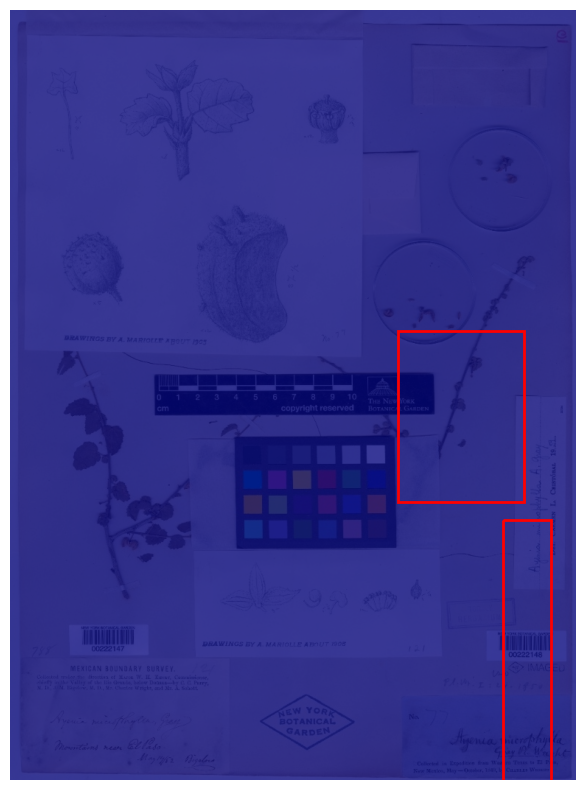

In [18]:
import matplotlib.patches as patches
def visualize_image_with_masks_and_boxes(image, masks, boxes):
    """
    Visualizes the image with overlaid masks and bounding boxes.
    
    Args:
    - image: PIL Image or a tensor of shape (C, H, W).
    - masks: Tensor of shape (num_masks, H, W).
    - boxes: List of bounding boxes, each defined as [xmin, ymin, xmax, ymax].
    """
    if torch.is_tensor(image):
        image = image.permute(1, 2, 0).numpy()
    if torch.is_tensor(masks):
        masks = masks.numpy()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    
    # Overlay masks with some transparency
    for i in range(masks.shape[0]):
        mask = masks[i]
        plt.imshow(mask, alpha=0.5, cmap='jet')  # Adjust alpha to make masks more or less transparent

    # Draw bounding boxes
    ax = plt.gca()  # Get the current Axes instance on the current figure
    for box in boxes:
        xmin, ymin, width, height = box[0], box[1], box[2], box[3]  # Convert to matplotlib format
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    plt.show()

# Example usage
# Assuming 'image' is loaded as a PIL Image or a tensor and 'boxes' is your list of bounding boxes
image_shape = (image.height, image.width) if not torch.is_tensor(image) else image.shape[1:]
boxes = [[526,435,171,232], [669,692,65,403]]  # Example boxes
masks = create_mask_from_boxes(image_shape, boxes)

# Now visualize
visualize_image_with_masks_and_boxes(image, masks, boxes)

In [19]:
class CustomDataset(Dataset):
    def __init__(self, annotations_df, img_dir, class_to_idx, neg_img_dir=None):
        self.annotations_df = annotations_df
        self.img_dir = img_dir
        self.class_to_idx = class_to_idx  # Mapping class names to integers
        self.neg_img_dir = neg_img_dir  # Directory containing negative samples
        self.neg_samples = os.listdir(neg_img_dir) if neg_img_dir else None

    def __len__(self):
        total_len = self.annotations_df['image_name'].nunique()
        if self.neg_samples:
            total_len += len(self.neg_samples)
        return total_len

    def __getitem__(self, idx):

        new_size = (1000, 1000)

        if idx < len(self.annotations_df["image_name"].unique()):
            unique_images = self.annotations_df['image_name'].unique()
            img_name = unique_images[idx]
            img_annotations = self.annotations_df[self.annotations_df['image_name'] == img_name]
            img_path = os.path.join(self.img_dir, img_name)
            image = Image.open(img_path).convert("RGB")
            original_size = image.size

            boxes = []
            labels = []
            for _, row in img_annotations.iterrows():
                box = [row['bbox_x'], row['bbox_y'], row['bbox_x'] + row['bbox_width'], row['bbox_y'] + row['bbox_height']]
                boxes.append(box)
                labels.append(self.class_to_idx[row['label_name']])
        

            adjusted_boxes = adjust_boxes(boxes, original_size, new_size)
            masks = create_mask_from_boxes(new_size, adjusted_boxes)
        
            boxes = torch.as_tensor(adjusted_boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            masks = torch.as_tensor(masks, dtype=torch.uint8)
        
            image_id = torch.tensor([idx])
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        else:
            # Handle negative samples
            neg_idx = idx - len(self.annotations_df["image_name"].unique())
            img_name = self.neg_samples[neg_idx]
            img_path = os.path.join(self.neg_img_dir, img_name)
            image = Image.open(img_path).convert("RGB")
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            masks = torch.zeros((0, new_size[0], new_size[1]), dtype=torch.uint8)
            image_id = torch.tensor([idx])
            area = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)

        transformations = Compose([
            Resize(new_size),
            ImageAugmentation(),
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        image = transformations(image)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['masks'] = masks
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd

        return image, target


In [20]:
class_to_idx = {class_name: i for i, class_name in enumerate(annotations_df['label_name'].unique())}

In [21]:
idx_to_class = {i: class_name for class_name, i in class_to_idx.items()}

In [22]:
train_dataset = CustomDataset(annotations_df=annotations_df,
                        img_dir='./bttai-nybg-2024/annotated_images',
                        class_to_idx=class_to_idx, neg_img_dir=None)


In [23]:
def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    
    # Stack images into a single tensor
    images = torch.stack(images, 0)
    
    return images, targets

In [24]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [25]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [26]:
def get_model_instance_segmentation(num_classes):
    
    model = maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)
    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # Now get the number of input features for the mask predictor and replace the mask head with a new one
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

In [27]:
model = get_model_instance_segmentation(len(class_to_idx) + 1)

In [28]:
model = model.to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# adagrad optimizer , weight_decay=0.001
# optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)

In [ ]:
# learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
num_epochs = 5  # Define the number of epochs

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        # lr_scheduler.step()

        running_loss += losses.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

In [30]:
def get_transform():
    return Compose([
        ImageAugmentation(),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [97]:
image_path = './bttai-nybg-2024/adjustment_pictures/00e0602c392d2d07.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Convert to PIL for compatibility with torchvision transforms
image_pil = Image.fromarray(image)

# Apply the same transformations as during training
transformations = get_transform()
transformed_img = transformations(image_pil)

# Add batch dimension
transformed_img = transformed_img.to(device)

In [98]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No gradients needed
    prediction = model([transformed_img])

In [ ]:
# # Using OpenCV to display the image with the predicted masks, but if this doesn't work, you can use matplotlib
# # Initialize an overlay that will accumulate all masks
# overlay = np.copy(image)

# # Threshold and process each mask
# threshold = 0.9
# for i, (mask, label) in enumerate(zip(prediction[0]['masks'], prediction[0]['labels'])):
#     # Apply threshold to convert the probability mask to a binary mask
#     binary_mask = mask[0] > threshold
    
#     # Convert binary mask to a NumPy array
#     mask_np = binary_mask.cpu().numpy().astype(np.uint8)
    
#     # Make mask pixels white
#     overlay[mask_np == 1] = [255, 255, 255]
    
#     # Optionally, find contours and draw the class label next to the object
#     contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     if contours:
#         # Draw class name near the first contour
#         cv2.putText(overlay, idx_to_class[label.item()], tuple(contours[0][0][0]), cv2.FONT_HERSHEY_SIMPLEX, 
#                     0.5, (0, 255, 0), 1)

# # Display the final image with all masks and class labels applied
# cv2.imshow('Overlay with all masks and class labels', overlay)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


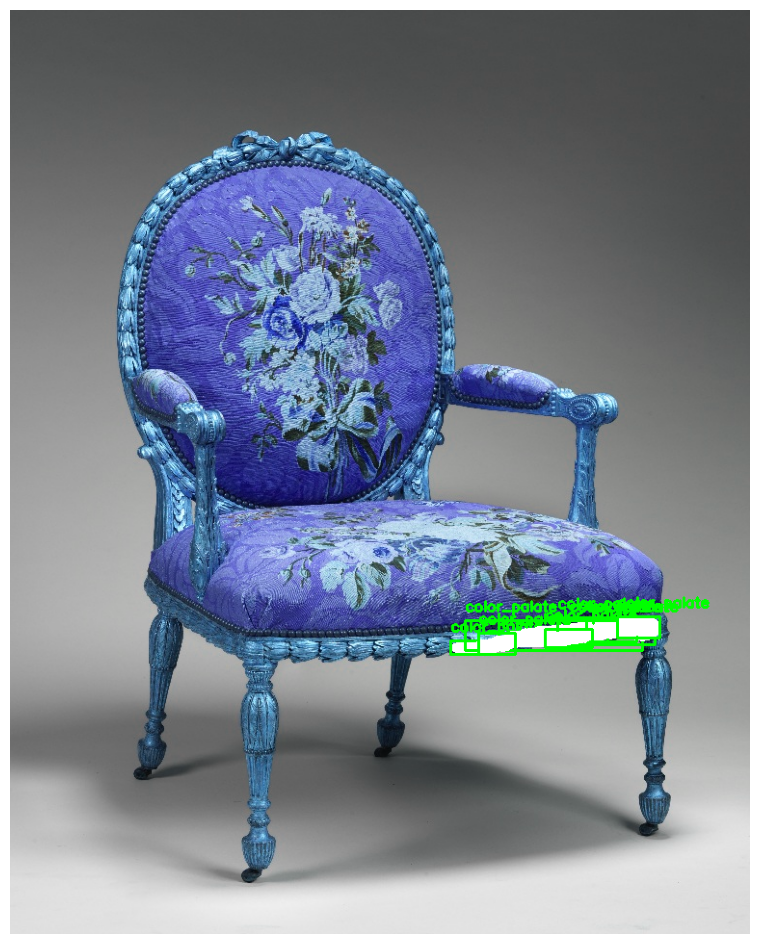

In [100]:
# Initialize an overlay that will accumulate all masks
overlay = np.copy(image)

# Convert from BGR (OpenCV default) to RGB for Matplotlib
overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

# Threshold and process each mask
threshold = 0.99
for i, (mask, label) in enumerate(zip(prediction[0]['masks'], prediction[0]['labels'])):
    # Apply threshold to convert the probability mask to a binary mask
    binary_mask = mask[0] > threshold
    
    # Convert binary mask to a NumPy array
    mask_np = binary_mask.cpu().numpy().astype(np.uint8)
    
    # Make mask pixels white in the overlay
    overlay[mask_np == 1] = [255, 255, 255]
    
    # Optionally, find contours and draw the class label next to the object
    contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Draw bounding box and class name near the first contour
        contour = contours[0]
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(overlay, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(overlay, idx_to_class[label.item()], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, (0, 255, 0), 2)

# Using Matplotlib to display the final image with all masks and class labels applied
plt.figure(figsize=(12, 12))
plt.imshow(overlay)
plt.axis('off')  # Hide axis
plt.show()
